<a href="https://colab.research.google.com/github/dapsavoie/agricultural_satellite_classifier/blob/master/test_new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data, Import Libraries

In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
model.save('jaccard_1_69.5%.h5')

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

import os

import tensorflow as tf

import pandas as pd

import numpy as np
# save numpy array as npy file
from numpy import asarray
from numpy import save

In [0]:
model.save('jaccard_1_69.5%.h5')

In [0]:
 # display file 

In [0]:
#!tar -xvf '/content/drive/My Drive/Agriculture-Vision.tar (1).gz' -C '/content/drive/My Drive/agri_vision/'

In [0]:
#load csv, train, val

base_dir =  '/content/drive/My Drive/agri_vision/'
train_folder = os.path.join(base_dir+ 'Agriculture-Vision/train/images/rgb')

val_folder = os.path.join(base_dir +'Agriculture-Vision/val/rgb/')


test_folder = os.path.join(base_dir + '/Agriculture-Vision/test/test_rgb/')


train = pd.read_csv('/content/drive/My Drive/agri_vision/final_encoded.csv')

#strip train index
train['index'] = train['index'].str.rstrip('.png')

In [0]:
train.drop(columns='Unnamed: 0', inplace=True)

In [0]:
train_2k = train.loc[0:1999]

In [34]:
train_2k

,index,cloud_shadow,double_planter,planter_skip,standing_water,waterway,weed_cluster
0,11T3V93AF_2280-3416-2792-3928,0,0,0,0,1,0
1,11T3V93AF_2373-2788-2885-3300,0,0,0,0,1,0
2,11T3V93AF_2721-2503-3233-3015,0,0,0,0,1,0
3,11T3V93AF_3083-3751-3595-4263,0,0,0,0,1,0
4,11T3V93AF_3877-4192-4389-4704,0,0,0,0,1,0
...,...,...,...,...,...,...,...
1995,7EMEVA1HK_4493-6700-5005-7212,0,0,0,0,1,1
1996,7EMEVA1HK_4655-2753-5167-3265,0,0,0,0,1,0
1997,7EMEVA1HK_4655-3265-5167-3777,0,0,0,0,1,0
1998,7EMEVA1HK_4979-3685-5491-4197,0,0,0,0,1,0


# Create Train and Val Images

In [0]:
# Load 2000 imag

In [36]:
!!!!train_image = []
for i in tqdm(range(2000)):
    img = image.load_img('/content/drive/My Drive/agri_vision/Agriculture-Vision/train/images/rgb/' + train_2k['index'][i] + '.jpg', color_mode='rgb', target_size=None)
    img = image.img_to_array(img)
    train_image.append(img)


100%|██████████| 2000/2000 [00:30<00:00, 64.89it/s]


In [0]:
X = np.array(train_image)

In [0]:
!!!!!!!!! save numpy array as npy file
from numpy import asarray
from numpy import save
# define data
data = X
# save to npy file
save('2000_xdata.npy', data)

In [0]:
#Create Validation Data Test 
val_index = list(os.listdir(val_folder))

In [0]:
val_image = []
for i in tqdm(range(300)):
    img = image.load_img(val_folder+val_index[i], color_mode='rgb', target_size=None)
    img = image.img_to_array(img)
    val_image.append(img)

In [0]:
val_array= np.array(val_image)

In [0]:
# define data
data = val_array
# save to npy file
save('300_val_data.npy', data)

#Create labels 

In [0]:
y = train[:1999]

In [0]:
y = np.array(train_2k.drop(['index'],axis=1))

In [41]:
y.shape 

(2000, 6)

In [0]:
# define data
#data = y
# save to npy file
#save('y_4000_data.npy', y)

In [0]:
X= np.load('/content/4000_xdata.npy')

FileNotFoundError: ignored

In [0]:
y =  np.load('/content/y_4000_data.npy')

FileNotFoundError: ignored

# Train Test Split 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None, test_size=0.1)

((1800, 512, 512, 3), (200, 512, 512, 3), (1800, 6), (200, 6))

# Model Layers and Summary Report 
# Compile and Fit 

In [0]:
from keras import backend as K


def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [0]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(512,512,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(3, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 508, 508, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 254, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 254, 254, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 121, 64)     

In [0]:
model.compile(optimizer='adam', loss=[jaccard_distance], metrics=['accuracy'])

In [26]:
model.fit(X_train, y_train, epochs=32, validation_data=(X_test, y_test), batch_size=4, class_weight='auto')

Train on 1800 samples, validate on 200 samples
Epoch 1/32
1800/1800 [==============================] - 544s 302ms/step - loss: 1.5980 - accuracy: 0.6878 - val_loss: 1.4912 - val_accuracy: 0.6500
Epoch 2/32
1800/1800 [==============================] - 545s 303ms/step - loss: 1.3388 - accuracy: 0.6950 - val_loss: 1.2137 - val_accuracy: 0.6500
Epoch 3/32
1800/1800 [==============================] - 537s 298ms/step - loss: 1.0513 - accuracy: 0.6950 - val_loss: 0.9767 - val_accuracy: 0.6500
Epoch 4/32
1800/1800 [==============================] - 533s 296ms/step - loss: 0.8517 - accuracy: 0.6950 - val_loss: 0.8378 - val_accuracy: 0.6500
Epoch 5/32
1800/1800 [==============================] - 534s 297ms/step - loss: 0.7408 - accuracy: 0.6950 - val_loss: 0.7626 - val_accuracy: 0.6500
Epoch 6/32
1800/1800 [==============================] - 536s 298ms/step - loss: 0.6790 - accuracy: 0.6950 - val_loss: 0.7192 - val_accuracy: 0.6500
Epoch 7/32
1800/1800 [==============================] - 536s 298m

In [0]:
model.save('jaccard_1_69.5%.h5')

In [0]:
from keras.models import load_model
test_model = tf.keras.models.load_model('5000_sequential.h5')

In [0]:
ls 85%_loss_65%_binary_sequential.h5

85%_loss_65%_binary_sequential.h5


In [0]:
test_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 508, 508, 16)      1216      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 254, 254, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 254, 254, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 250, 250, 32)      12832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 121, 121, 64)     

# Load Image and Predict Probability it belongs to a class 

In [0]:
# Load Image and Predict Probability it belongs to a class 

In [0]:
img = image.load_img('/content/drive/My Drive/agri_vision/Agriculture-Vision/train/images/rgb/1W6YEHJJU_10032-6287-10544-6799.jpg', target_size=None)
img = image.img_to_array(img)
img = img/255

In [0]:
img.shape

(512, 512, 3)

In [0]:
classes = np.array(train.columns[1:])
classes

array(['cloud_shadow', 'double_planter', 'planter_skip', 'standing_water',
       'waterway', 'weed_cluster'], dtype=object)

In [0]:
proba = model.predict(img.reshape(1, 512, 512, 3))
proba

array([[6.5071037e-04, 1.0740142e-02, 1.7803586e-03, 5.0106314e-03,
        2.4591589e-01, 7.3590225e-01]], dtype=float32)

In [0]:
top_3 = np.argsort(proba[0])[:-4:-1]
top_3

array([5, 4, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weed_cluster (0.736)
waterway (0.246)
double_planter (0.0107)


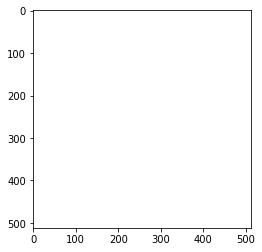

In [0]:
import matplotlib.pyplot as plt

for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

In [0]:
classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1, 512, 512, 3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

IndexError: ignored

# Test Data

In [0]:
test_index = pd.DataFrame(os.listdir(test_folder))
test_index['index'] = test_index[0]

test_index.drop(columns = 0, inplace=True)
test_index = test_index.loc[0:199]

In [0]:
test_index

,index
0,C7CPXCQFB_818-792-1330-1304.jpg
1,AA6FKGHN2_2468-10654-2980-11166.jpg
2,TCGYUIB7I_2653-8327-3165-8839.jpg
3,D1M7QKGIN_3999-2721-4511-3233.jpg
4,AA6FKGHN2_1640-5812-2152-6324.jpg
...,...
195,MTTWHAFPN_2659-577-3171-1089.jpg
196,4AZJLIGYZ_7731-3019-8243-3531.jpg
197,2K21T1ZGV_2442-1934-2954-2446.jpg
198,Y6UDNUNDT_3652-2850-4164-3362.jpg


In [0]:
 
test_image = []
for i in tqdm(range(200)):
    img = image.load_img('/content/drive/My Drive/agri_vision/Agriculture-Vision/test/test_rgb/' + test_index['index'][i], color_mode='rgb', target_size=None)
    img = image.img_to_array(img)
    test_image.append(img)
img = image.img_to_array(test_image)


100%|██████████| 199/199 [00:01<00:00, 117.36it/s]


ValueError: ignored

In [0]:
 test_index = pd.DataFrame(os.listdir(test_folder))


In [0]:
img = image.load_img('/content/drive/My Drive/agri_vision/Agriculture-Vision/test/test_rgb/' + test_index['index'][i], color_mode='rgb', target_size=None)

In [0]:
for i in tqdm(range(199)):
    img = image.load_img('/content/drive/My Drive/agri_vision/Agriculture-Vision/test/test_rgb/' + test_index['index'][i], color_mode='rgb', target_size=None)

In [0]:
img = image.img_to_array(img)

In [0]:
test_image.append(img)

In [0]:
test_x = np.array(test_image)

In [0]:
model.predict(test_x)

# save model

In [0]:
import os

import tensorflow as tf
from tensorflow import keras

In [0]:
model = create_model()

NameError: ignored